Dataset

In [ ]:
# https://drive.google.com/drive/folders/1s762G9PvR77-qYW8fvG-BpK167AwSpU1?usp=sharing
# https://drive.google.com/file/d/1paYbtgHor4b06uPZ9FIRm1W_rNUJrW0V/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1.Install and Import Data

In [ ]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install diffusers transformers einops accelerate

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-evpsxxtu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-evpsxxtu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from diffusers import AutoencoderKL
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm.auto import tqdm
from typing import Callable
import os
import pandas as pd
from typing import Tuple, List
import clip
from torchvision.transforms import ToPILImage
from tqdm import trange

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
ROOT = '/content/drive/MyDrive/Colab/1508Y'
IMAGE_DIR = os.path.join(ROOT, 'img_subset')
ATTR_PATH = os.path.join(ROOT, 'list_attr_celeba.txt')
SPLIT_PATH = os.path.join(ROOT, 'list_eval_partition.txt')
SUBSET_ATTR_PATH = "/content/drive/MyDrive/Colab/1508Y/list_attr_subset.txt"
SUBSET_EVAL_PATH = "/content/drive/MyDrive/Colab/1508Y/list_eval_subset.txt"

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from torchvision import transforms

class CelebACustom(Dataset):
    def __init__(self, split='train', transform=None):
        self.img_dir = IMAGE_DIR
        self.transform = transform

        if os.path.exists(SUBSET_ATTR_PATH):
            self.attr_df = pd.read_csv(
                SUBSET_ATTR_PATH, sep=r'\s+', header=1, index_col=0
            )
        else:
            attr_csv = SUBSET_ATTR_PATH.replace('list_attr_celeba.txt', 'list_attr_celeba.csv')
            self.attr_df = pd.read_csv(attr_csv, index_col=0)

        if os.path.exists(SUBSET_EVAL_PATH):
            eval_df = pd.read_csv(
                SUBSET_EVAL_PATH, sep=r'\s+', header=1
            )
        else:
            split_csv = SUBSET_EVAL_PATH.replace('list_eval_partition.txt', 'list_eval_partition.csv')
            eval_df = pd.read_csv(split_csv)

        if 'partition' in eval_df.columns:
            part_col = 'partition'
        elif 'split' in eval_df.columns:
            part_col = 'split'
        else:
            part_col = eval_df.columns[1]
        split_map = {'train': 0, 'valid': 1, 'test': 2}
        img_names = eval_df.loc[eval_df[part_col] == split_map[split], eval_df.columns[0]].tolist()
        available = set(os.listdir(self.img_dir))
        print(len(available))
        self.img_names = [n for n in img_names if n in available]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img = Image.open(os.path.join(self.img_dir, name)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        attr = torch.tensor(self.attr_df.loc[name].values, dtype=torch.float32)
        return img, attr

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(128),
    transforms.ToTensor(),
])

train_data = CelebACustom(
    split='train',
    transform=transform
)
dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

print("sample num：", len(train_data))
img, attr = train_data[0]
print("image shape：", img.shape)
print("atrr shape：", attr.shape)

5020
sample num： 5018
image shape： torch.Size([3, 128, 128])
atrr shape： torch.Size([40])


In [ ]:
df = pd.read_csv(SUBSET_ATTR_PATH, sep=r'\s+', header=1, index_col=0)
print("num：", len(df.columns))
print("attr：")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

num： 40
attr：
0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


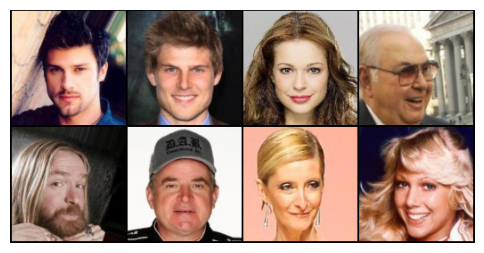

In [ ]:
ch = next(iter(dataloader))[0]
grid = vutils.make_grid(ch[:8], nrow=4)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1,2,0))

# 2.Model

## 2.1 VAE:AutoencoderKL
we use stable diffussion's AutoencoderKL

In [ ]:
#AutoencoderKL
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae.eval()

# vae_preprocess = transforms.Compose([
#     transforms.CenterCrop(178),
#     transforms.Resize(64),
#     transforms.ToTensor(),
# ])
def encode_batch(imgs):
    x = imgs * 2-1  # →[-1,1]
    with torch.no_grad():
        dist = vae.encode(x.to(device)).latent_dist
        z = dist.sample() * vae.config.scaling_factor  # [B,4,64,64]
    return z
def decode_latent(z):
    z_in = z / vae.config.scaling_factor
    out = vae.decode(z_in).sample
    img = (out / 2 + 0.5).clamp(0, 1)
    return img

## 2.2 Pretrained clip

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# def get_clip_feats_batch(img_batch, prompts_orig, prompts_tgt):
#     pil_list = [ToPILImage()(img.cpu()) for img in img_batch]
#     inputs = torch.stack([clip_preprocess(p) for p in pil_list], dim=0).to(device)
#     f_img = F.normalize(clip_model.encode_image(inputs), dim=-1)

#     toks_o = clip.tokenize(prompts_orig).to(device)
#     f_txt_o = F.normalize(clip_model.encode_text(toks_o), dim=-1)

#     toks_t = clip.tokenize(prompts_tgt).to(device)
#     f_txt_t = F.normalize(clip_model.encode_text(toks_t), dim=-1)
#     return f_img, f_txt_o, f_txt_t

# Use clip's built-in transform to extract mean/std dynamically
clip_mean = torch.tensor(clip_preprocess.transforms[-1].mean).view(1, 3, 1, 1).to(device)
clip_std = torch.tensor(clip_preprocess.transforms[-1].std).view(1, 3, 1, 1).to(device)

def get_clip_image_features_only(img_batch):
    pil_list = [ToPILImage()(img.cpu()) for img in img_batch]
    inputs = torch.stack([clip_preprocess(p) for p in pil_list], dim=0).to(device)
    return F.normalize(clip_model.encode_image(inputs), dim=-1)


def get_clip_feats_batch(img_batch, prompts_orig, prompts_tgt):
    img_batch = F.interpolate(img_batch, size=(224, 224), mode='bilinear', align_corners=False)
    img_batch = (img_batch - clip_mean) / clip_std  # normalize using CLIP stats
    f_img = F.normalize(clip_model.encode_image(img_batch), dim=-1)

    toks_o = clip.tokenize(prompts_orig).to(device)
    f_txt_o = F.normalize(clip_model.encode_text(toks_o), dim=-1)

    toks_t = clip.tokenize(prompts_tgt).to(device)
    f_txt_t = F.normalize(clip_model.encode_text(toks_t), dim=-1)
    return f_img, f_txt_o, f_txt_t



#  3.Latent modification

## 3.0 Some helper function

In [ ]:
def sample_attr_paths(attr_name: str, N: int) -> Tuple[List[str], List[str]]:
    df = pd.read_csv(SUBSET_ATTR_PATH, sep='\s+', header=1, index_col=0)
    pos_df = df[df[attr_name] == 1]
    neg_df = df[df[attr_name] == -1]

    if len(pos_df) < N or len(neg_df) < N:
        raise ValueError( f"not enough {N}，"f"{attr_name}=1 :{len(pos_df)} ，" f"{attr_name}=-1 :{len(neg_df)}")

    pos_list = random.sample(list(pos_df.index), N)
    neg_list = random.sample(list(neg_df.index), N)
    pos_paths = [os.path.join(IMAGE_DIR, fn) for fn in pos_list]
    neg_paths = [os.path.join(IMAGE_DIR, fn) for fn in neg_list]
    return pos_paths, neg_paths


In [ ]:
# Helper function for displaying images

def compare_reconstruction(img_orig, img_recon, img_edited_linear, n=5):
    plt.figure(figsize=(n*3, 9))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(img_orig[i].permute(1, 2, 0).cpu().numpy().clip(0, 1))
        plt.axis('off')
        if i == 0: plt.title('Original')

        plt.subplot(3, n, n+i+1)
        plt.imshow(img_recon[i].detach().permute(1, 2, 0).cpu().numpy().clip(0, 1))
        plt.axis('off')
        if i == 0: plt.title('VAE Recon')

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(img_edited_linear[i].detach().permute(1, 2, 0).cpu().numpy().clip(0, 1))
        plt.axis('off')
        if i == 0: plt.title('Edited (linear)')

    plt.tight_layout()
    plt.show()

    # Clean up memory explicitly
    plt.close('all')
    gc.collect()
    torch.cuda.empty_cache()

##3.1  Interpolation

#### Training AdaIN

In [ ]:
class PairedSmileDataset(Dataset):
    def __init__(self, attr_name="Smiling", n=5000):
        self.pos_paths, self.neg_paths = sample_attr_paths(attr_name, n)
        self.transform = transforms.ToTensor()
        self.length = min(len(self.pos_paths), len(self.neg_paths))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_neg = self.transform(Image.open(self.neg_paths[idx]).convert("RGB"))
        img_pos = self.transform(Image.open(self.pos_paths[idx]).convert("RGB"))
        return img_neg, img_pos

In [ ]:
class AdaINModulator(nn.Module):
    def __init__(self, embed_dim=512, latent_channels=4):
        super().__init__()
        self.fc_gamma = nn.Linear(embed_dim, latent_channels)
        self.fc_beta = nn.Linear(embed_dim, latent_channels)

    def forward(self, z, clip_embed):
        gamma = self.fc_gamma(clip_embed).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        beta = self.fc_beta(clip_embed).unsqueeze(-1).unsqueeze(-1)
        return gamma * z + beta

In [ ]:
import gc  # Add this at the top of your script

def train_adain_modulator(model, dataloader, optimizer, device, clip_extractor, clip_tokenizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        for img_neg, img_pos in pbar:
            img_neg = img_neg.to(device)
            img_pos = img_pos.to(device)

            text_inputs = clip_tokenizer(["a person with a smile"] * img_neg.size(0)).to(device)
            with torch.no_grad():
                text_embed = clip_extractor.encode_text(text_inputs).float()

            z_neg = encode_batch(img_neg)
            z_pos = encode_batch(img_pos)

            z_mod = model(z_neg, text_embed)

            recon = decode_latent(z_mod)

            img_pos_resized = F.interpolate(img_pos, size=recon.shape[-2:], mode='bilinear', align_corners=False)

            # Loss: compare decoded image with resized target
            loss_mse = F.mse_loss(recon, img_pos_resized)
            with torch.no_grad():
                f_recon = get_clip_image_features_only(recon)
                f_target = get_clip_image_features_only(img_pos_resized)

            loss_clip = 1 - F.cosine_similarity(f_recon, f_target).mean()
            loss = loss_mse + 0.1 * loss_clip

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

            # === Free memory every step ===
            del img_neg, img_pos, text_inputs, text_embed, z_neg, z_pos, z_mod, recon, img_pos_resized, loss_mse, loss_clip, loss
            torch.cuda.empty_cache()
            gc.collect()

        print(f"Epoch {epoch+1} avg loss: {total_loss / len(dataloader):.4f}")

        # Optional: clear cache after each epoch
        torch.cuda.empty_cache()
        gc.collect()


In [ ]:
train_dataset = PairedSmileDataset(attr_name="Smiling", n=2400)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

adain_mod = AdaINModulator(embed_dim=512, latent_channels=4).to(device)
optimizer = torch.optim.Adam(adain_mod.parameters(), lr=1e-4)

train_adain_modulator(adain_mod, train_loader, optimizer, device, clip_model, clip.tokenize, epochs=10)


#### Interpolation


In [ ]:
def interpolate_latent_with_text_guidance(original_image_tensor, prompt_orig, prompt_target, adain_modulator, alpha=1.0):
    """
    Uses a trained AdaIN modulator to guide latent interpolation based on text prompts.

    Args:
        original_image_tensor (Tensor): Input image tensor [B, 3, H, W].
        prompt_orig (str): Original text prompt.
        prompt_target (str): Target text prompt.
        adain_modulator (nn.Module): Trained AdaIN modulator.
        alpha (float): Interpolation factor.

    Returns:
        Tensor: Edited latent tensor [B, C, H, W]
    """
    try:
      if original_image_tensor.max() > 1.0:
          original_image_tensor = original_image_tensor / 255.0

      z_orig = encode_batch(original_image_tensor)  # [B, 4, 16, 16]

      with torch.no_grad():
          f_img, f_txt_orig, f_txt_target = get_clip_feats_batch(
              original_image_tensor,
              [prompt_orig] * original_image_tensor.shape[0],
              [prompt_target] * original_image_tensor.shape[0]
          )

          clip_dir = f_txt_target - f_txt_orig
          clip_dir = clip_dir / (clip_dir.norm(dim=-1, keepdim=True) + 1e-6)

      with torch.no_grad():
          z_shifted = adain_modulator(z_orig, clip_dir.float())

      z_edited = (1 - alpha) * z_orig + alpha * z_shifted
      return z_edited, decode_batchwise(z_orig)

    finally:
        del z_orig, f_img, f_txt_orig, f_txt_target, clip_dir
        if 'z_shifted' in locals(): del z_shifted
        torch.cuda.empty_cache()
        gc.collect()


def decode_batchwise(latent_tensor, batch_size=4):
    decoded_images = []
    try:
        for i in trange(0, latent_tensor.shape[0], batch_size, desc="Decoding latent vectors"):
            batch_latents = latent_tensor[i:i+batch_size].to(device)
            decoded_batch = decode_latent(batch_latents)
            decoded_images.append(decoded_batch.cpu())
            del batch_latents, decoded_batch
            torch.cuda.empty_cache()
            gc.collect()

        return torch.cat(decoded_images, dim=0)

    finally:
        del decoded_images
        torch.cuda.empty_cache()
        gc.collect()


Decoding latent vectors: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


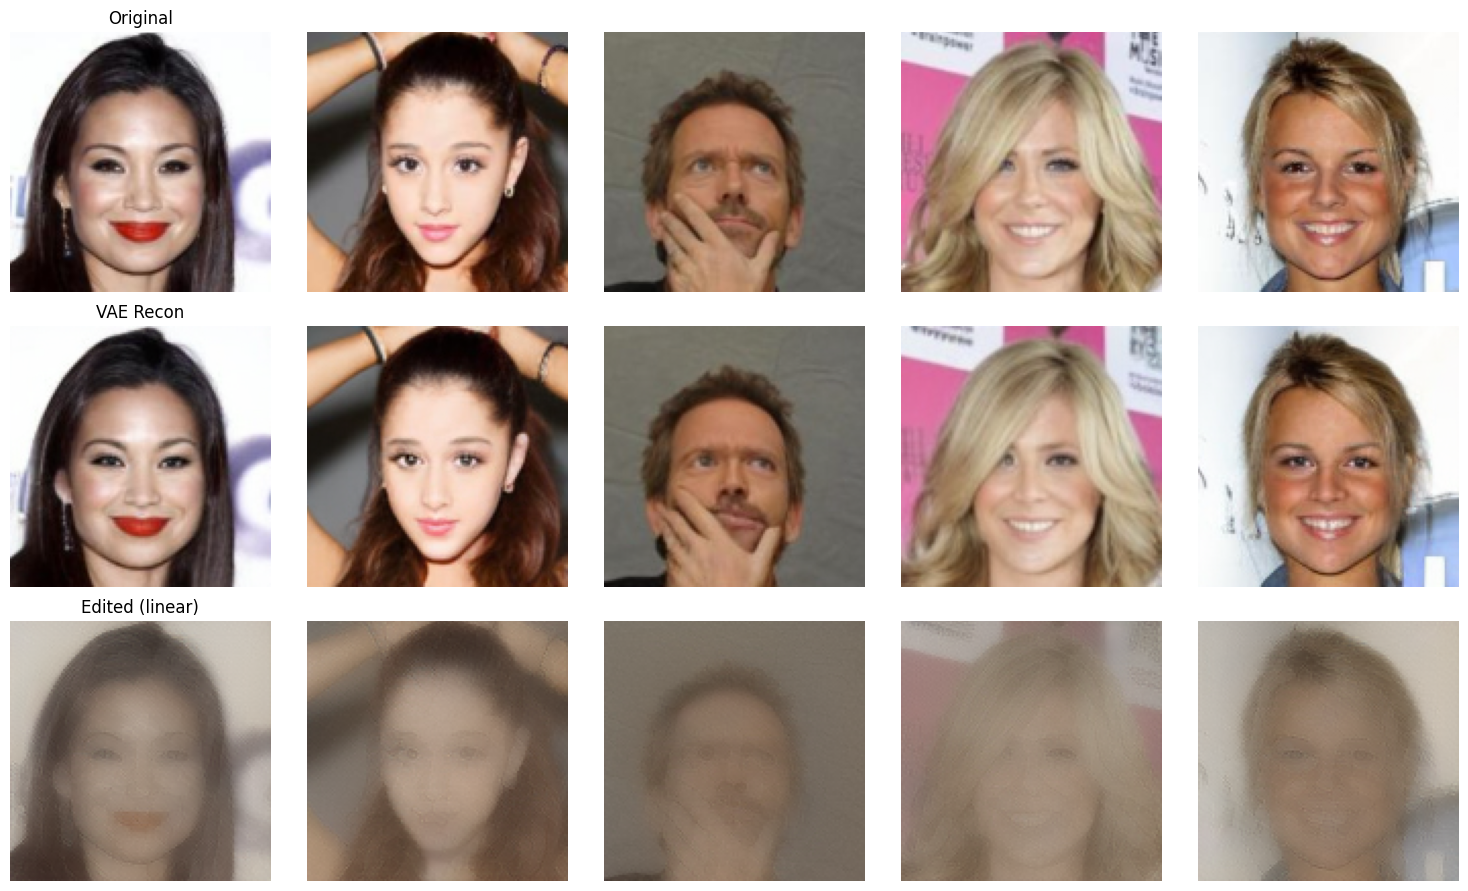

0

In [ ]:
example_batch = next(iter(dataloader))[0].to(device)
# Assume adain_mod is your trained model and loaded to device
z_edited, recon_images = interpolate_latent_with_text_guidance(
    original_image_tensor=example_batch,
    prompt_orig = "a serious person staring blankly",
    prompt_target = "a person with a smile",
    # prompt_target = "a cheerful person smiling brightly",
    adain_modulator=adain_mod,
    alpha=0.6
)

# Decode the edited latents
edited_images = decode_batchwise(z_edited)

# Display results (limit to 5 for visualization)
compare_reconstruction(
    img_orig=example_batch[:5].cpu(),
    img_recon=recon_images[:5],
    img_edited_linear=edited_images[:5]
)

del z_edited, recon_images, edited_images
torch.cuda.empty_cache()
gc.collect()